# Week 4: Gradient Descent

In [1]:
%matplotlib inline

import scipy                                              
import numpy as np
from scipy import io
from scipy import optimize
import matplotlib.pyplot as plt

Loading the data and showing the size of the resulting dataset:

In [2]:
hand_data_dict = scipy.io.loadmat('data/mnistAll.mat')

train_data = np.moveaxis(hand_data_dict['mnist']['train_images'][0][0], -1, 0)
train_classes = hand_data_dict['mnist']['train_labels'][0][0].ravel()

test_data = np.moveaxis(hand_data_dict['mnist']['test_images'][0][0], -1, 0)
test_classes = hand_data_dict['mnist']['test_labels'][0][0].ravel()

print("shape of train_data = ", np.shape(train_data))
print("shape of train_classes = ", np.shape(train_classes), '\n')

print("shape of test_data = ", np.shape(test_data))
print("shape of test_classes = ", np.shape(test_classes), '\n')

 # Splitting the data:
b37 = (train_classes == 3) + (train_classes == 7)

train_data_37 = train_data[b37]
train_classes_37 = train_classes[b37]

b37 = (test_classes == 3) + (test_classes == 7)

test_data_37 = test_data[b37]
test_classes_37 = test_classes[b37]

print("shape of train_data_37 = ", np.shape(train_data_37))
print("shape of train_classes_37 = ", np.shape(train_classes_37), '\n')

print("shape of test_data_37 = ", np.shape(test_data_37))
print("shape of test_classes_37 = ", np.shape(test_classes_37))

shape of train_data =  (60000, 28, 28)
shape of train_classes =  (60000,) 

shape of test_data =  (10000, 28, 28)
shape of test_classes =  (10000,) 

shape of train_data_37 =  (12396, 28, 28)
shape of train_classes_37 =  (12396,) 

shape of test_data_37 =  (2038, 28, 28)
shape of test_classes_37 =  (2038,)


A quick sanity check:

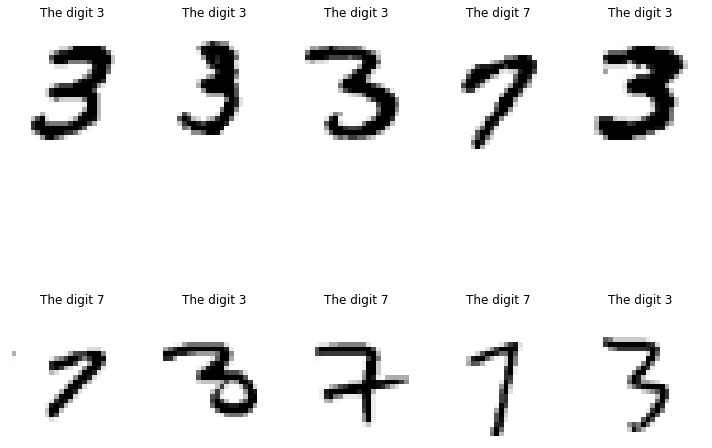

In [3]:
  # sanity check:
plt.figure(figsize=(10,10)) 
for i in range(10):
    plt.subplot(2, 5, i + 1);
    I = np.reshape(train_data_37[i, :],(28, 28))
    plt.imshow(I, extent=(0, 28, 0, 28), cmap = plt.cm.gray_r);
    plt.title('The digit ' + str(train_classes_37[i]));
    plt.axis('off')
plt.tight_layout()    
plt.show()

We want the data to be vectors:

In [4]:
train_37_shape = np.shape(train_data_37)
test_37_shape = np.shape(test_data_37)

rspd_train_data_37 = np.reshape(train_data_37, (train_37_shape[0], train_37_shape[1] * train_37_shape[2]))
rspd_test_data_37 = np.reshape(test_data_37, (test_37_shape[0], test_37_shape[1] * test_37_shape[2]))

print("shape of rspd_train_data_37 = ", np.shape(rspd_train_data_37))
print("shape of rspd_test_data_37 = ", np.shape(rspd_test_data_37))

max_val = np.maximum(np.max(rspd_train_data_37), np.max(rspd_test_data_37))

  # scaling averything between 0 and 1:
rspd_train_data_37 = rspd_train_data_37 / max_val
rspd_test_data_37 = rspd_test_data_37 / max_val

amount_of_data = train_classes_37.size
size_of_data = np.shape(rspd_train_data_37)[1]

print('Amount of data:', amount_of_data)
print('size of data vectors:', size_of_data)

  # classes are 0 and 1:
train_classes_37_01 = train_classes_37 == 7
test_classes_37_01 = test_classes_37 == 7

shape of rspd_train_data_37 =  (12396, 784)
shape of rspd_test_data_37 =  (2038, 784)
Amount of data: 12396
size of data vectors: 784


We use the following timer for Python. This timer measures wallclock time, rather than CPU time. However, the same holds for the functions `tic()` and `toc()` in Matlab. 
Note that the wallclock time is approximately the CPU time divided by the number of cores (assuming that the computer is solely used for the computation and not for other things at the same time).

In [5]:
from timeit import default_timer as timer

start = timer()
for i in range(10000000):
    pass
end = timer()
print(end - start, 'seconds')

0.8643938999999996 seconds


Some helpfull functions:

In [6]:
  # binary cross entropy loss:
  # t ~ true label
  # y ~ predicted label
def E(t, y):
    return -(t * np.log(y) + (1 - t) * np.log(1 - y))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

**Our general descent algorithm:** <br>

The following function takes `direct_fun` as an argument, which is the function we use to compute the update step in every gradient descent algorithm.
We also just give all possible parameters to the functions, and feed them all to `direct_fun`, which will only use some of them.

In [7]:
def general_descent(direct_fun, # function used in the update step
                   name, # name of the algorithm (used in the plot)
                   train_data = rspd_train_data_37,
                   train_classes = train_classes_37_01,
                   test_data = rspd_test_data_37,
                   test_classes = test_classes_37_01,
                   max_iter = 4000,  # number of epochs
                   ret = False,  # return final weights
                   lr = 0.01,  # learning rate
                   mom = 0.01,  # momentum 
                   lmb = 0.1, # decay rate
                   mb = False # use minibatches (and how large) 
                  ):
    
      # split validation data
    split_index = int(train_classes.size * 4 / 5)
    val_data = train_data[split_index:]
    train_data = train_data[:split_index]
    val_classes = train_classes[split_index:]
    train_classes = train_classes[:split_index]
    
      # early stopping
    patience = 50  # way too high but gives good results
    min_delta = 0
    counter = 0
    old_acc = 0
    
      # timing:
    startT = timer()
    
    train_data_size = train_classes.size
    val_data_size = val_classes.size
    test_data_size = test_classes.size    
    
      # staring value (Glorot heuristic / Xavier initialization):
    w = (2 * np.random.rand(train_data[1].size) - 1) * np.sqrt(6 / (train_data[1].size + 1))
        
      # initializations:
    train_acc = np.zeros(max_iter)
    val_acc = np.zeros(max_iter)
    test_acc = np.zeros(max_iter)
    train_loss_arr = np.zeros(max_iter)
    val_loss_arr = np.zeros(max_iter)
    test_loss_arr = np.zeros(max_iter)
    
    direction = 0
    new_grad = 0
    old_grad = 0
       
    for idx in range(max_iter):       
        
          # predictions:
        pred_train = sigmoid(w @ train_data.T)
        pred_val = sigmoid(w @ val_data.T)
        pred_test  = sigmoid(w @ test_data.T)
        
          # accuracies:
        train_acc[idx] = np.sum((pred_train >= 1/2) == train_classes) / train_data_size
        val_acc[idx] = np.sum((pred_val >= 1/2) == val_classes) / val_data_size
        test_acc[idx] = np.sum((pred_test >= 1/2) == test_classes) / test_data_size
          
          # losses:
        train_loss_arr[idx] = 1 / train_data_size * np.nan_to_num(np.sum(E(train_classes, pred_train)))
        val_loss_arr[idx] = 1 / val_data_size * np.nan_to_num(np.sum(E(val_classes, pred_val)))
        test_loss_arr[idx]  = 1 / test_data_size  * np.nan_to_num(np.sum(E(test_classes, pred_test)))
        
          # early stopping
        if val_acc[idx] - val_acc[idx - 1] <= min_delta:
            counter += 1
        else:
            counter = 0
        if counter > patience:
            print("Stopped early at epoch {}".format(idx))
            break
        
        if name == "Conjugate Gradient Descent":
            old_grad = new_grad
            new_grad = vanilla_update(pred_train, train_classes, train_data, train_data_size)
        
          # gradient:
        direction = direct_fun(pred_train = pred_train,
                               train_classes = train_classes,
                               train_data = train_data,
                               train_data_size = train_data_size,
                               old_grad = old_grad,
                               new_grad = new_grad,
                               mom = mom,
                               direction = direction,
                               lmb = lmb,
                               w = w,
                               mb = mb) 
        
          # descent:
        w -= lr * direction 
        
          # no need to time the plots:
    endT = timer()   
    
          # the interesting values:
    print('Final train classification error: ', '%.2f' % ((1 - train_acc[idx]) * 100), '%')
    print('Final train loss: ', '%.4f' %  train_loss_arr[idx])
    
    print('Final test classification error: ', '%.2f' % ((1- test_acc[idx]) * 100), '%')
    print('Final test loss: ', '%.4f' % test_loss_arr[idx])
    
    print('Time taken: ', '%.2f' % (endT - startT), ' seconds')
    
          # plotting the accuracy:
    plt.plot(np.arange(0, idx, 1), train_acc[:idx], label = 'train accuracy')
    plt.plot(np.arange(0, idx, 1), val_acc[:idx], label='val accuracy')
    plt.plot(np.arange(0, idx, 1), test_acc[:idx], label = 'test accuracy')
    plt.title(name + ': Accuracies')
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
          # plotting the losses:
    plt.plot(np.arange(0, idx, 1), train_loss_arr[:idx], label = 'train loss')
    plt.plot(np.arange(0, idx, 1), val_loss_arr[:idx], label='val loss')
    plt.plot(np.arange(0, idx, 1), test_loss_arr[:idx], label = 'test loss')
    plt.title(name + ': Loss')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    if ret:
        return w
    pass

## Vanilla Gradient Descent:

In [8]:
def vanilla_update(pred_train, train_classes, train_data, train_data_size, **kwargs):
    return (pred_train - train_classes) @ train_data / train_data_size 

def vanilla_gradient_descent(lr, max_iter):
    general_descent(direct_fun = vanilla_update, name = 'Vanilla Gradient Descent',
                   lr = lr, max_iter = max_iter)

Stopped early at epoch 254
Final train classification error:  2.02 %
Final train loss:  0.0703
Final test classification error:  2.70 %
Final test loss:  0.0792
Time taken:  3.75  seconds


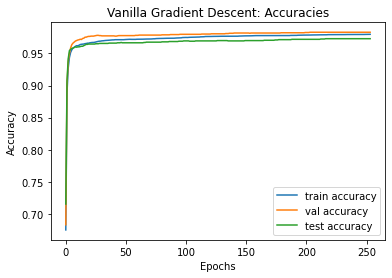

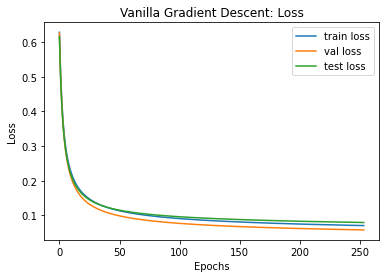

In [9]:
vanilla_gradient_descent(lr = 0.1, max_iter = 10000)

### Early stopping disadvantages:

Early stopping can be very useful, especially to prevent the network doing 'unnecessary' iterations. Once the model is sufficiently trained and the performance stops increasing, further iterations are not useful anymore. In fact, it can even be harmful as this type of behaviour leads to overfitting on the training data. However, early stopping can also prevent an algorithm from getting out of a local optimum. For the network to continue exploring the space outside a local optimum the performance will likely decrease slightly, and early stopping can prevent this exploration. An alternative way to do early stopping is to only consider it when the performance stagnates (rather than decreases), as this usually indicates that the network has converged. A second alternative is just to increase the patience, meaning the network has to decrease for quite a long time before stopping early, but this may result in suboptimal final parameters. In that case a checkpoint with the best weights so far should be returned, but this is spatially expensive.

### Test for different values of $\eta$

Stopped early at epoch 933
Final train classification error:  3.58 %
Final train loss:  0.2379
Final test classification error:  3.83 %
Final test loss:  0.2324
Time taken:  13.72  seconds


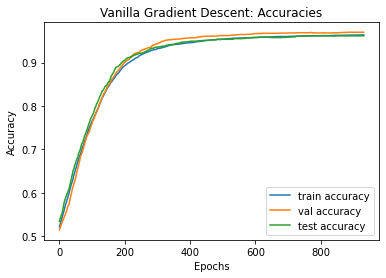

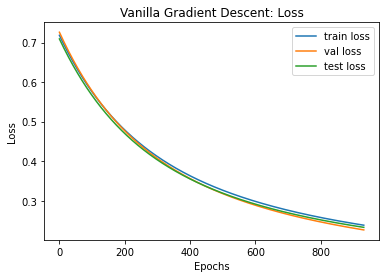

Stopped early at epoch 537
Final train classification error:  3.13 %
Final train loss:  0.1870
Final test classification error:  3.73 %
Final test loss:  0.1827
Time taken:  8.41  seconds


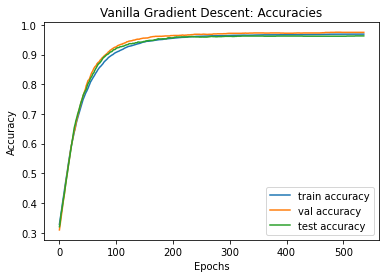

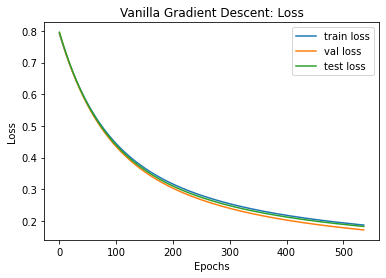

Stopped early at epoch 334
Final train classification error:  3.08 %
Final train loss:  0.1354
Final test classification error:  3.53 %
Final test loss:  0.1363
Time taken:  5.56  seconds


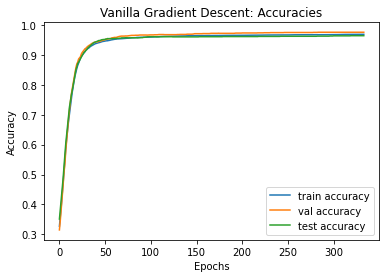

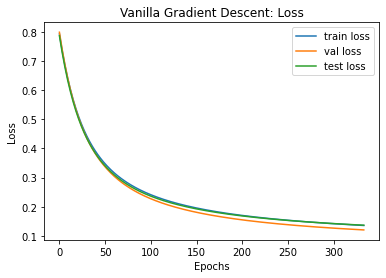

Stopped early at epoch 175
Final train classification error:  2.60 %
Final train loss:  0.1087
Final test classification error:  3.43 %
Final test loss:  0.1120
Time taken:  2.87  seconds


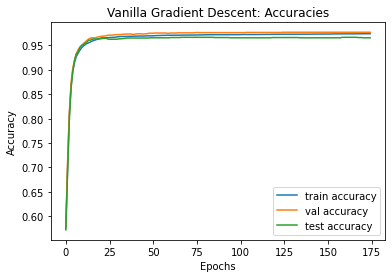

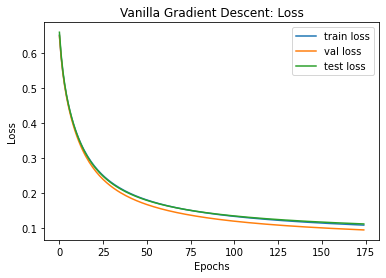

Stopped early at epoch 150
Final train classification error:  2.22 %
Final train loss:  0.0806
Final test classification error:  2.99 %
Final test loss:  0.0872
Time taken:  2.54  seconds


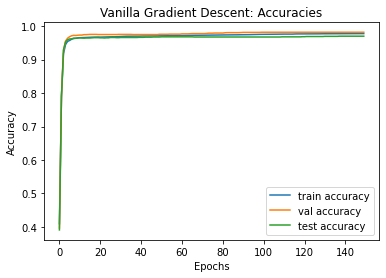

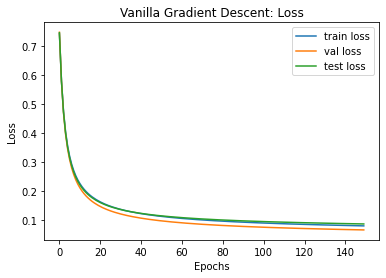

Stopped early at epoch 317
Final train classification error:  1.49 %
Final train loss:  0.0512
Final test classification error:  2.11 %
Final test loss:  0.0624
Time taken:  5.05  seconds


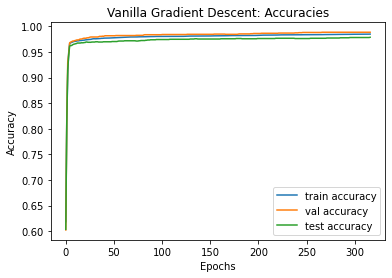

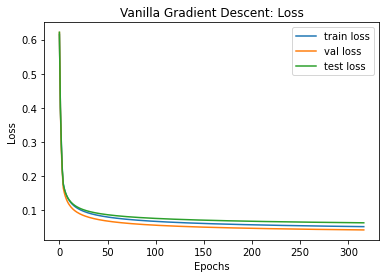

Stopped early at epoch 174
Final train classification error:  1.34 %
Final train loss:  0.0447
Final test classification error:  1.86 %
Final test loss:  0.0586
Time taken:  2.94  seconds


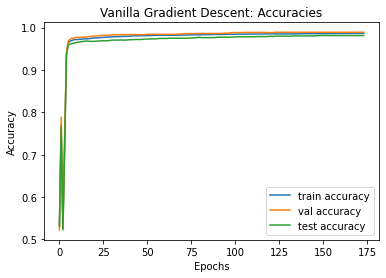

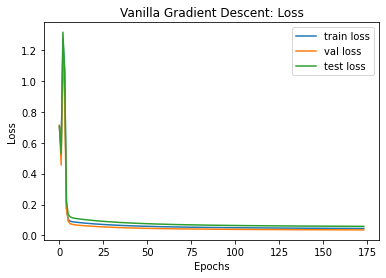

In [10]:
for eta in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
    vanilla_gradient_descent(lr = eta, max_iter = 10000)

There is an outlier for eta = 0.001, as this error is even lower than eta = 0.01, which almost has to be due to chance. Generally with eta < 0.01 the network fails to converge, and gets stuck in a local optimum because the learning rate is too low to get out before the patience of the early stopping mechanism kicks in. In fact, this might still be the case for large learning rates, as the final accuracy keeps increasing with the learning rate. This suggests that the network is not fluctuating around the actual optimum yet and thus still hasn't converged. However, it's possible that this is already the case but through coincedence the final value was a bit closer to the actual optimum each time. 

## Momentum:

In [11]:
def momentum_update(pred_train, train_classes, train_data, train_data_size, mom, direction, **kwargs):
    return vanilla_update(pred_train, train_classes, train_data, train_data_size) + mom * direction

def momentum_gradient_descent(lr, mom, max_iter):
    general_descent(direct_fun = momentum_update, name = 'Momentum Gradient Descent',
                   lr = lr, mom = mom, max_iter = max_iter)

Stopped early at epoch 458
Final train classification error:  2.92 %
Final train loss:  0.1152
Final test classification error:  3.73 %
Final test loss:  0.1186
Time taken:  6.87  seconds


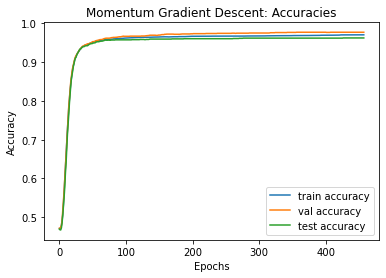

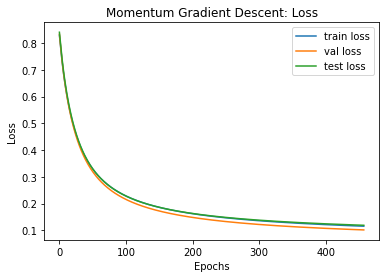

In [12]:
momentum_gradient_descent(lr = 0.01, mom = 0.1, max_iter = 10000)

## Weight decay:

In [13]:
def decay_update(pred_train, train_classes, train_data, train_data_size, mom, direction, lmb, w,
                 **kwargs):
    return momentum_update(pred_train, train_classes, train_data, train_data_size, mom, direction)
    + np.multiply(lmb / np.arange(1, train_data_size + 1, 1), w)

def decay_gradient_descent(lr, mom, lmb, max_iter):
    general_descent(direct_fun = decay_update, name = 'Weight Decay Gradient Descent',
                   lr = lr, mom = mom, max_iter = max_iter, lmb = lmb)

Stopped early at epoch 336
Final train classification error:  3.21 %
Final train loss:  0.1320
Final test classification error:  3.34 %
Final test loss:  0.1331
Time taken:  5.10  seconds


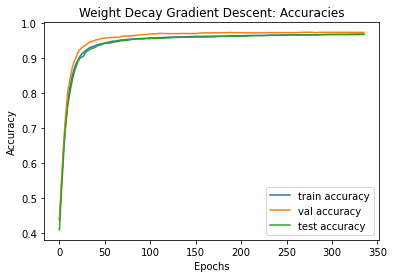

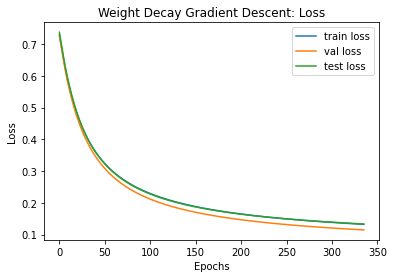

In [14]:
decay_gradient_descent(lr = 0.01, mom = 0.1, lmb = 0.1, max_iter = 1000)

## Newton method:

In [15]:
def newton_update(pred_train, train_classes, train_data, train_data_size, lmb, **kwargs):
    dsize = train_data.shape[1]
    mul = np.multiply(pred_train, (np.ones_like(train_classes) - pred_train))
    data_mul = train_data * mul[:, np.newaxis]
    H = train_data.T @ data_mul / train_data_size + lmb / dsize * np.identity(dsize)
      # note: no need to compute the inverse of H, to obtain H^{-1}\nabla E, we just solve the linear system Hx = \nabla E for x
    return np.linalg.solve(H, vanilla_update(pred_train, train_classes, train_data, train_data_size))    

def newton_descent(max_iter, lmb):
    general_descent(direct_fun = newton_update, name = 'Newton Gradient Descent',
                   lr = 1, max_iter = max_iter, lmb = lmb)

Final train classification error:  0.31 %
Final train loss:  0.0122
Final test classification error:  2.01 %
Final test loss:  0.0667
Time taken:  4.60  seconds


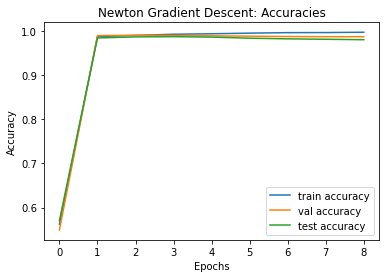

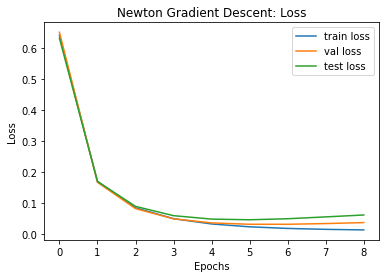

In [16]:
newton_descent(max_iter = 10, lmb = 0.1)

Since Newton's method uses such a different amount of epochs, the patience is too high for early stopping to have an effect on this. However, we can see from the graph that after the 5th epoch the loss starts to increase and the accuracy decrease.

Final train classification error:  0.62 %
Final train loss:  0.0323
Final test classification error:  1.47 %
Final test loss:  0.0486
Time taken:  2.21  seconds


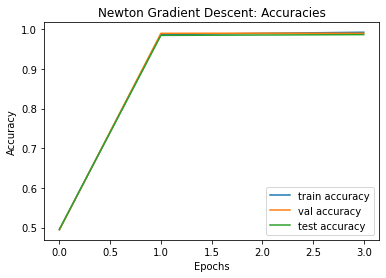

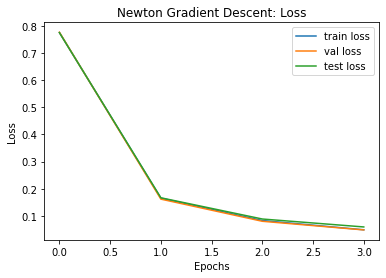

In [17]:
newton_descent(max_iter = 5, lmb = 0.1)

## Line search:

In [18]:
def line_search_update(pred_train, train_classes, train_data, train_data_size, w, **kwargs):
    direction = vanilla_update(pred_train, train_classes, train_data, train_data_size)
    opt_func = lambda gamma: np.nan_to_num(np.sum(E(train_classes, sigmoid((w - gamma * direction) @ train_data.T))))
    gamma_opt = scipy.optimize.minimize_scalar(opt_func).x          
    return gamma_opt * direction

def line_search(max_iter):
    general_descent(direct_fun = line_search_update, name = 'Line search',
                   lr = 1, max_iter = max_iter)

Final train classification error:  0.86 %
Final train loss:  0.0301
Final test classification error:  1.62 %
Final test loss:  0.0493
Time taken:  28.45  seconds


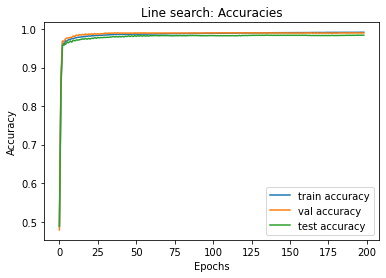

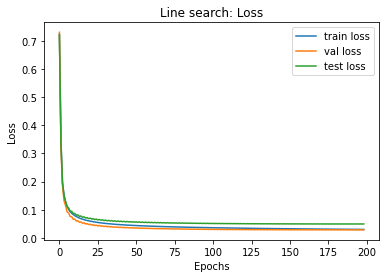

In [19]:
line_search(max_iter = 200)

## Conjugate Gradient Descent:

In [20]:
def conjugate_descent_update(pred_train, train_classes, train_data, train_data_size, old_grad, new_grad, w, direction, **kwargs):
    beta = np.dot(new_grad - old_grad, new_grad) / np.dot(old_grad, old_grad)
    new_direction = -new_grad + beta * direction
    opt_func = lambda gamma: np.nan_to_num(np.sum(E(train_classes, sigmoid((w - gamma * direction) @ train_data.T))))
    gamma_opt = scipy.optimize.minimize_scalar(opt_func).x          
    return gamma_opt * new_direction

def conjugate_descent(max_iter):
    general_descent(direct_fun = line_search_update, name = 'Conjugate Gradient Descent',
                   lr = 1, max_iter = max_iter)

Final train classification error:  0.83 %
Final train loss:  0.0290
Final test classification error:  1.57 %
Final test loss:  0.0496
Time taken:  15.49  seconds


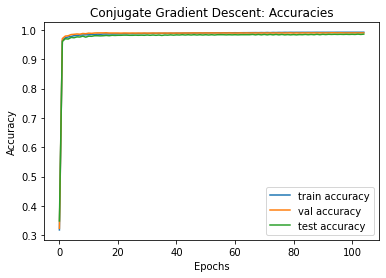

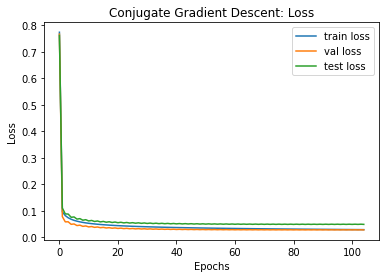

In [21]:
conjugate_descent(max_iter = 106)

## Stochastic Gradient Descent:

In [22]:
def mb_update(pred_train, train_classes, train_data, train_data_size, mb, **kwargs):
    rnd_idx = (np.arange(train_data_size) < mb)
    np.random.shuffle(rnd_idx)
    return vanilla_update(pred_train[rnd_idx], train_classes[rnd_idx], train_data[rnd_idx], mb)

def mb_gradient_descent(lr, max_iter, mb):
    general_descent(direct_fun = mb_update, name = 'Stochastic Gradient Descent',
                   lr = lr, max_iter = max_iter, mb = mb)

Stopped early at epoch 677
Final train classification error:  2.72 %
Final train loss:  0.1039
Final test classification error:  3.43 %
Final test loss:  0.1058
Time taken:  7.02  seconds


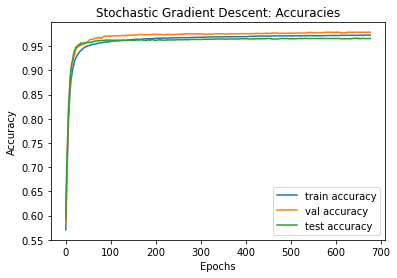

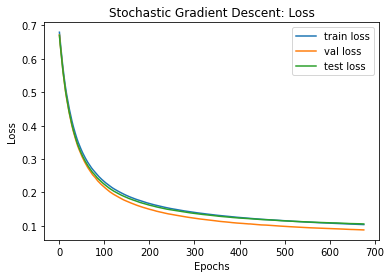

In [23]:
mb_gradient_descent(lr = 0.01, max_iter = 5000, mb = train_classes_37_01.size / 100)